In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from matplotlib.pyplot import cm 

warnings.filterwarnings("ignore")

% matplotlib inline

## Question 2

### Download dataset

In [41]:
import os
import urllib.request
import zipfile

data_dir = '/data/flights'
    
data_dir = os.path.join(data_dir)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

yr = [2014, 2015, 2016]
mm = np.arange(1,13)

for y in yr:
    for m in mm:
        DATA_URL = 'https://transtats.bts.gov/PREZIP/On_Time_On_Time_Performance_{}_{}.zip'.format(y, m)

        filename = DATA_URL.split('/')[-1]
        filepath = os.path.join(data_dir, filename)

        if not os.path.exists(filepath):
            filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath)
            zip_ref = zipfile.ZipFile(filepath, 'r')
            zip_ref.extractall(data_dir)
            zip_ref.close()
            print('Successfullly downloaded', filename)

### Change data-format to reduce memory usage

First, we will take an example table and inspect the memory usage for each data type: float, int and object

In [ ]:
for dtype in ['float64','int64','object']:
    data_dtype = data_fl.select_dtypes(include=[dtype])
    tt_usage_b = data_dtype.memory_usage(deep=True).sum()
    tt_usage_mb = tt_usage_b / 1024 ** 2
    print("Total memory usage for {} columns: {:.3f} MB".format(dtype, tt_usage_mb))

In [3]:
def memory_usage(df):
    tt_usage = df.memory_usage(deep=True).sum() / 1024 ** 2
    print("Total memory usage {:.3f} MB".format(tt_usage))

Before merging all the table, we will apply down-casting without losing informaiton on int, float data type. We will also change the NAN data type as well as use category datatypte to store object variable.

In [2]:
def down_cast(df, filename):
    
    print('Downcasting...' + filename.split('/')[-1])
    df_int = df.select_dtypes(include=['int'])
    df_float = df.select_dtypes(include=['float'])
    df_obj = df.select_dtypes(include=['object'])
    
    df_int_cv = df_int.apply(pd.to_numeric, downcast='unsigned')
    df_float_cv = df_float.apply(pd.to_numeric, downcast='float')
    null_columns= df_float_cv.columns[df_float_cv.isnull().all()]
    df_float_cv[null_columns] = df_float_cv[null_columns].astype('float16')
    
    df_obj_cv = pd.DataFrame()
    for col in df_obj.columns:
        num_unique_values = len(df_obj[col].unique())
        num_total_values = len(df_obj[col])
        if num_unique_values / num_total_values < 0.5:
            df_obj_cv.loc[:,col] = df_obj[col].astype('category')
        else:
            df_obj_cv.loc[:,col] = df_obj[col]
            
    pd_new = pd.concat([df_int_cv, df_obj_cv, df_float_cv], axis=1)
    
    return pd_new

In [62]:
memory_usage(data_fl)
data_fl_cv = down_cast(data_fl)
memory_usage(data_fl_cv)

Total memory usage 800.439 MB
Downcasting...
Total memory usage 199.354 MB


### Process each .csv file and combine them

In [3]:
data_fl = pd.DataFrame(data=None)

yr = [2014, 2015, 2016]
mm = np.arange(1,13)
for y in yr:
    for m in mm:
        filename = '/data/flights/On_Time_On_Time_Performance_{}_{}.csv'.format(y, m)
        print('Processing ' + filename + '...')

        data_tmp = pd.read_csv(filename)
        data_tmp_cv = down_cast(data_tmp, filename)
        data_fl = data_fl.append(data_tmp_cv)

Processing /data/flights/On_Time_On_Time_Performance_2014_1.csv...
Downcasting...On_Time_On_Time_Performance_2014_1.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_2.csv...
Downcasting...On_Time_On_Time_Performance_2014_2.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_3.csv...
Downcasting...On_Time_On_Time_Performance_2014_3.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_4.csv...
Downcasting...On_Time_On_Time_Performance_2014_4.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_5.csv...
Downcasting...On_Time_On_Time_Performance_2014_5.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_6.csv...
Downcasting...On_Time_On_Time_Performance_2014_6.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_7.csv...
Downcasting...On_Time_On_Time_Performance_2014_7.csv
Processing /data/flights/On_Time_On_Time_Performance_2014_8.csv...
Downcasting...On_Time_On_Time_Performance_2014_8.csv
Processing /data/flights/On_Time_On_Time

In [11]:
# Save data locally
# data_fl.to_pickle('/data/data_flight')

In [2]:
data_fl = pd.read_pickle('/data/data_flight')
data_fl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17256548 entries, 0 to 460948
Columns: 110 entries, ActualElapsedTime to Year
dtypes: category(2), float32(44), float64(25), object(18), uint16(9), uint32(2), uint8(10)
memory usage: 9.1+ GB


In [3]:
data_fl.head()

,ActualElapsedTime,AirTime,AirlineID,ArrDel15,ArrDelay,ArrDelayMinutes,ArrTime,ArrTimeBlk,ArrivalDelayGroups,CRSArrTime,...,TailNum,TaxiIn,TaxiOut,TotalAddGTime,UniqueCarrier,Unnamed: 109,WeatherDelay,WheelsOff,WheelsOn,Year
0,384.0,359.0,19805,0.0,13.0,13.0,1238.0,1200-1259,0.0,1225,...,N338AA,5.0,20.0,NaN,AA,NaN,NaN,934.0,1233.0,2014
1,389.0,340.0,19805,0.0,1.0,1.0,1226.0,1200-1259,0.0,1225,...,N338AA,6.0,43.0,NaN,AA,NaN,NaN,940.0,1220.0,2014
2,NaN,NaN,19805,NaN,NaN,NaN,NaN,1200-1259,NaN,1225,...,N323AA,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,2014
3,379.0,346.0,19805,1.0,59.0,59.0,1324.0,1200-1259,3.0,1225,...,N327AA,16.0,17.0,NaN,AA,NaN,59.0,1022.0,1308.0,2014
4,385.0,347.0,19805,1.0,110.0,110.0,1415.0,1200-1259,7.0,1225,...,N323AA,6.0,32.0,NaN,AA,NaN,110.0,1122.0,1409.0,2014


In [3]:
# Make a copy of the data to prevent reload
# Will improve in future version given the memmory taken
data = data_fl.copy()

In [4]:
# Visualize columns
np.array(data.columns)

array(['ActualElapsedTime', 'AirTime', 'AirlineID', 'ArrDel15', 'ArrDelay',
       'ArrDelayMinutes', 'ArrTime', 'ArrTimeBlk', 'ArrivalDelayGroups',
       'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime', 'CancellationCode',
       'Cancelled', 'Carrier', 'CarrierDelay', 'DayOfWeek', 'DayofMonth',
       'DepDel15', 'DepDelay', 'DepDelayMinutes', 'DepTime', 'DepTimeBlk',
       'DepartureDelayGroups', 'Dest', 'DestAirportID', 'DestAirportSeqID',
       'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips',
       'DestStateName', 'DestWac', 'Distance', 'DistanceGroup',
       'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID',
       'Div1LongestGTime', 'Div1TailNum', 'Div1TotalGTime',
       'Div1WheelsOff', 'Div1WheelsOn', 'Div2Airport', 'Div2AirportID',
       'Div2AirportSeqID', 'Div2LongestGTime', 'Div2TailNum',
       'Div2TotalGTime', 'Div2WheelsOff', 'Div2WheelsOn', 'Div3Airport',
       'Div3AirportID', 'Div3AirportSeqID', 'Div3LongestGTime',
       'Div3TailNum', 'Div

In [5]:
data['Flights'].describe()

count    17256548.0
mean            1.0
std             0.0
min             1.0
25%             1.0
50%             1.0
75%             1.0
max             1.0
Name: Flights, dtype: float64

From the Flights information we could see that each entry represent one flight informaiton. Therefore, by taking the count of enties that group by the required information, we could evaluate the how busy a departure/arrival airport is.

### Part A: Identify top 10 busiest departure and arrivel airport over time

In [6]:
# Find all the depart airport that has been on the top 10
def findTimeAirport(data, airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='Origin', agg_way='count'):
    
    # Create column with key information
    df_agg = data.groupby([timeperiod, airptkey]).agg({agg_key:agg_way})
    g = df_agg[agg_key].groupby(level=0, group_keys=False)
    topn_df = g.nlargest(topn)

    dict_departID = {}

    multi_index = topn_df.index
    values = topn_df.values

    for i in range(len(multi_index)):
        mm, departID = multi_index[i]
        if departID not in dict_departID:
            dict_departID[departID] = []

    key_list = list(dict_departID.keys())
    # Fill in the occurance
    for j in range(len(topn_df.index.levels[0])):
        curr_departID = list(topn_df.index.get_level_values(1))[j * topn: j * topn + topn]
        curr_values = values[j * topn: j * topn + topn]
        for departID in key_list:
            if departID in curr_departID:
                index_departID = curr_departID.index(departID)
                dict_departID[departID].append(curr_values[index_departID])
            else:
                dict_departID[departID].append(np.nan)
    
    return list(topn_df.index.levels[0]), dict_departID

In [7]:
# We will take month as the bin for study busy level: number of departure(arraive)/month
# Creat unique identifier 'YY-M'
data['YY-M'] = data['Year'].astype(int) * 100 +  data['Month'].astype(int)

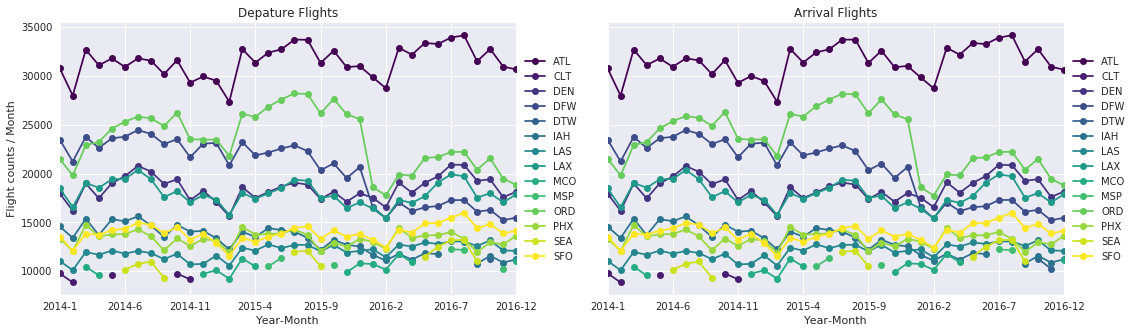

In [8]:
# Plot the change of flight counts/ month over year for top ten busiest airports
fig, ax = plt.subplots(1,2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(18)

yy_m, top10_depart = findTimeAirport(data, airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='Origin', agg_way='count')
top10_depart = pd.DataFrame(top10_depart)
top10_depart['Year-Month'] = [str(yy_m[i]//100) + '-' + str(yy_m[i]-yy_m[i]//100*100) for i in range(len(yy_m))]

top10_depart.plot(x='Year-Month', marker='o', ax=ax[0], cmap=plt.cm.get_cmap('viridis'))
ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[0].set_title('Depature Flights')
ax[0].set_ylabel('Flight counts / Month')

yy_m, top10_arr = findTimeAirport(data, airptkey='Dest', timeperiod='YY-M', topn=10, agg_key='Origin', agg_way='count')
top10_arr = pd.DataFrame(top10_arr)
top10_arr['Year-Month'] = [str(yy_m[i]//100) + '-' + str(yy_m[i]-yy_m[i]//100*100) for i in range(len(yy_m))]

top10_arr.plot(x='Year-Month', marker='o', ax=ax[1], cmap=plt.cm.get_cmap('viridis'))
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[1].set_title('Arrival Flights')

plt.show()

From the results we could see that within an airpoty departure and arrival fight counts/mouth is very similar. We could obtain correlation coefficitient between the two for each airport. 

In [9]:
# Write function to calculate correlation coefficient and slope of linear regression, dealing with nan
def corrcoef_slope(x1, x2):
    
    mean_x1 = np.nanmean(x1)
    mean_x2 = np.nanmean(x2)
    std_x1 = np.nanstd(x1)
    std_x2 = np.nanstd(x2)
    
    coefficient = np.nanmean(np.multiply(x1 - mean_x1, x2 - mean_x2) / (std_x1 * std_x2))
    slope = np.nanmean(np.multiply(x1 - mean_x1, x2 - mean_x2) / (std_x1 * std_x1))
    
    return coefficient, slope

In [10]:
lr_list = []
top10_list = top10_depart.iloc[0][0:-1].sort_values(ascending=False)
for i in range(10):
    airport_name = top10_list.index[i]
    depart_counts = np.array(top10_depart[airport_name]).reshape(-1,1)
    arr_counts = np.array(top10_arr[airport_name]).reshape(-1,1)
    
    lr_list.append(corrcoef_slope(depart_counts, arr_counts))

In [11]:
lr_df = pd.DataFrame(lr_list, index=list(top10_list.index)[:10], columns=['Corrcoef', 'Slope']).T
lr_df

,ATL,DFW,ORD,LAX,DEN,IAH,SFO,PHX,LAS,CLT
Corrcoef,0.999951,0.999996,0.999951,0.999977,0.999876,0.999976,0.999954,0.999973,0.999973,0.999636
Slope,1.001676,1.000405,1.002533,1.000254,0.997310,1.001162,1.004164,0.997700,1.000974,0.989285


From the correlation coefficient and slope of linear regression between departure and arrival flight counts, we could see that within an airpoty departure and arrival fight counts/mouth is almost identical to each other. Therefore, we could use only the counts of departure flight to estimate business level of the airport.

### Identify the top 150 busiest airport during 2016 (last 12 month)

In [12]:
# Obtain top150_depart and arr counts airports
_, top150_depart = findTimeAirport(data[data['Year']==2016], airptkey='Origin', timeperiod='Year', topn=150)
_, top150_arr = findTimeAirport(data[data['Year']==2016], airptkey= 'Dest', timeperiod='Year', topn=150)

In [13]:
# Sort airpot busy level
new_key_list = set(top150_depart.keys())|(set(top150_arr.keys()))
top150_busy = {}
while len(new_key_list) > 0:
    key_tmp = new_key_list.pop()
    key_val_depart = top150_depart[key_tmp] if key_tmp in top150_depart else np.nan
    key_val_arr = top150_arr[key_tmp] if key_tmp in top150_arr else np.nan
    top150_busy[key_tmp] = np.nansum([key_val_depart, key_val_arr])
    
top150_busy =  sorted(top150_busy.items(), key=lambda x: x[1], reverse=True)

In [14]:
top150_busy_df = pd.DataFrame(top150_busy)
top150_busy_df.columns =['IATA', 'FlightCounts']

In [15]:
# Load latitude and longitude information for each airport
# Orginal information downloaded from https://openflights.org/data.html
airport_info = pd.read_csv('/data/airports.csv')

In [13]:
# Add latitude and longitude information to top150_busy_df
latitude = []
longitude = []

for i in range(len(top150_busy_df)):
    latitude.append(airport_info[airport_info['IATA'] == top150_busy_df.iloc[i]['IATA']]['Latitude'].values[0])
    longitude.append(airport_info[airport_info['IATA'] == top150_busy_df.iloc[i]['IATA']]['Longitude'].values[0])

top150_busy_df['lat'] = latitude
top150_busy_df['lon'] = longitude

In [21]:
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='ShuangLiData', api_key='x9P8Cu5eM4AcKJtGKGN8')

In [22]:
# Make use of plotly library to generate the figure
df = top150_busy_df
df['text'] = df['IATA'] + '<br>FlightCounts: ' + (df['FlightCounts']).astype(str)

scl = [[0,"rgb(50, 20, 20)"],[0.35,"rgb(164, 0, 0)"],[0.5,"rgb(206, 22, 22)"],\
    [0.6,"rgb(255, 0, 0)"],[0.7,"rgb(255, 92, 92)"],[1,"rgb(255, 250, 250)"] ]

flights = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df['lon'],
        lat = df['lat'],
        text = df['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = "circle",
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = df['FlightCounts'],
            cmax = df['FlightCounts'].max(),
            colorbar=dict(
                title="FlightCounts2016"
            )
        ))]

layout = dict(
        title = 'Top 150 busiest airports in 2016',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict(data=flights, layout=layout )
py.iplot( fig, validate=False, filename='Top_150_busiest_airports_2016' )

### Part B: Top 10 airports with the highest departure delays

To be able to study the delay of top 10 airports with the highest departure delays, we first need to identify the candidate airports. We seperate by year and look into the ones with highest departure delay freqency and delay minutes respectively.

In [23]:
data.head()

,ActualElapsedTime,AirTime,AirlineID,ArrDel15,ArrDelay,ArrDelayMinutes,ArrTime,ArrTimeBlk,ArrivalDelayGroups,CRSArrTime,...,TaxiIn,TaxiOut,TotalAddGTime,UniqueCarrier,Unnamed: 109,WeatherDelay,WheelsOff,WheelsOn,Year,YY-M
0,384.0,359.0,19805,0.0,13.0,13.0,1238.0,1200-1259,0.0,1225,...,5.0,20.0,NaN,AA,NaN,NaN,934.0,1233.0,2014,201401
1,389.0,340.0,19805,0.0,1.0,1.0,1226.0,1200-1259,0.0,1225,...,6.0,43.0,NaN,AA,NaN,NaN,940.0,1220.0,2014,201401
2,NaN,NaN,19805,NaN,NaN,NaN,NaN,1200-1259,NaN,1225,...,NaN,NaN,NaN,AA,NaN,NaN,NaN,NaN,2014,201401
3,379.0,346.0,19805,1.0,59.0,59.0,1324.0,1200-1259,3.0,1225,...,16.0,17.0,NaN,AA,NaN,59.0,1022.0,1308.0,2014,201401
4,385.0,347.0,19805,1.0,110.0,110.0,1415.0,1200-1259,7.0,1225,...,6.0,32.0,NaN,AA,NaN,110.0,1122.0,1409.0,2014,201401


In [24]:
# Obtain top 10_depart and arr delay airports by frequency and total delay minutes
yy_m, top_delay_freq = findTimeAirport(data[data['DepDelay']>0], airptkey='Origin', timeperiod='Year', topn=10, agg_key='DepDelayMinutes', agg_way='count')
yy_m, top_delay_min = findTimeAirport(data[data['DepDelay']>0], airptkey='Origin', timeperiod='Year', topn=10, agg_key='DepDelayMinutes', agg_way='sum')
top_delay_freq = pd.DataFrame(top_delay_freq)
top_delay_min = pd.DataFrame(top_delay_min)

colors = plt.cm.get_cmap('inferno').colors
# Create colormap based on name or the first situation
airport_id = list(top_delay_freq.iloc[0].sort_values(ascending=False).index)
color_map = {}
color_step = int(256/len(airport_id))
for i in range(len(airport_id)):
    color_map[airport_id[i]] = colors[i * color_step + color_step]

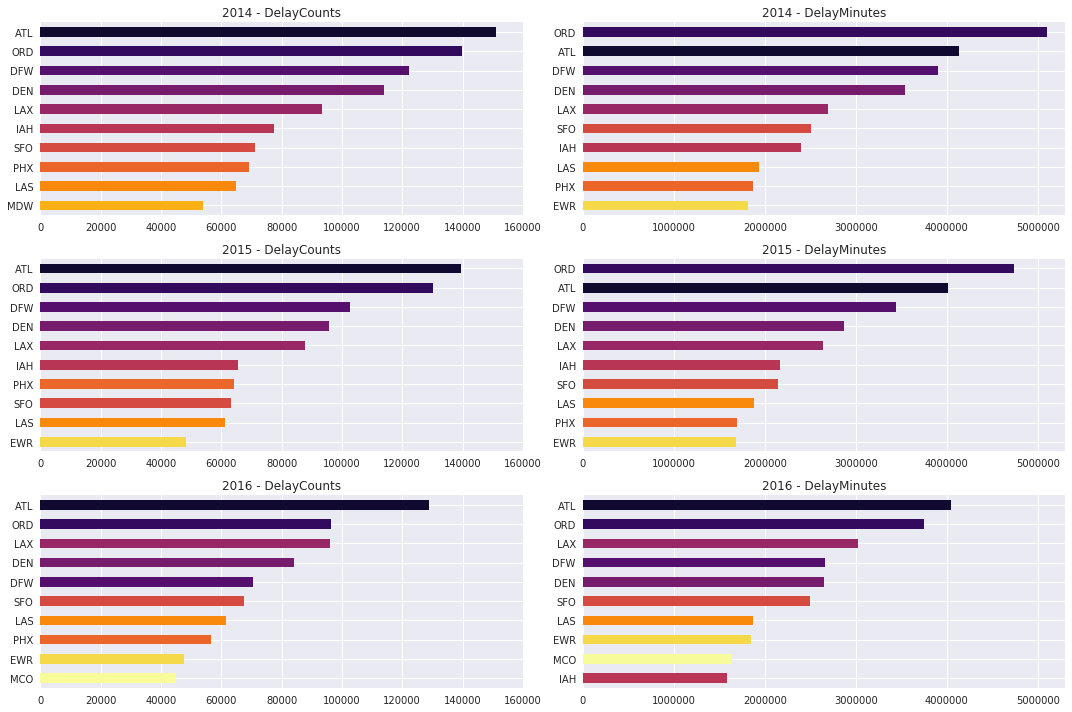

In [25]:
fig, ax = plt.subplots(3,2)
fig.set_figheight(10)
fig.set_figwidth(15)

for i in range(3):
    color_series_freq = []
    color_series_min = []
    series_freq = top_delay_freq.iloc[i][~top_delay_freq.iloc[i].isnull()].sort_values(ascending=True)
    series_min = top_delay_min.iloc[i][~top_delay_min.iloc[i].isnull()].sort_values(ascending=True)
    for j in range(len(series_freq)):
        color_series_freq.append(color_map[series_freq.index[j]])
    for j in range(len(series_min)):
        color_series_min.append(color_map[series_min.index[j]])
    series_freq.plot.barh(ax=ax[i][0], color=color_series_freq, xlim=(0, 160000))
    series_min.plot.barh(ax=ax[i][1], color=color_series_min, xlim=(0, 5300000))
    ax[i][0].set_title("{} - DelayCounts".format(yy_m[i]))
    ax[i][1].set_title("{} - DelayMinutes".format(yy_m[i]))
    
plt.tight_layout()

From the above result, we could see that the top 10 airport for delay frequency (DelayCounts) and dealy severity (DelayMinutes) change little across the years. Besides, DelayMinutes are different from DelayCounts at a detailed level, indicating that the causes for DelayCounts and DelayMinutes might be different.

Next, we looked into the relationship between time of the year and delay frequency as well as severity.

In [26]:
def standardization(df):
    
    for i in range(len(df.columns)):
        col_max = np.nanmax(df[df.columns[i]])
        col_min = np.nanmin(df[df.columns[i]])
        df[df.columns[i]] = (df[df.columns[i]] - col_min)/col_max
    
    return df

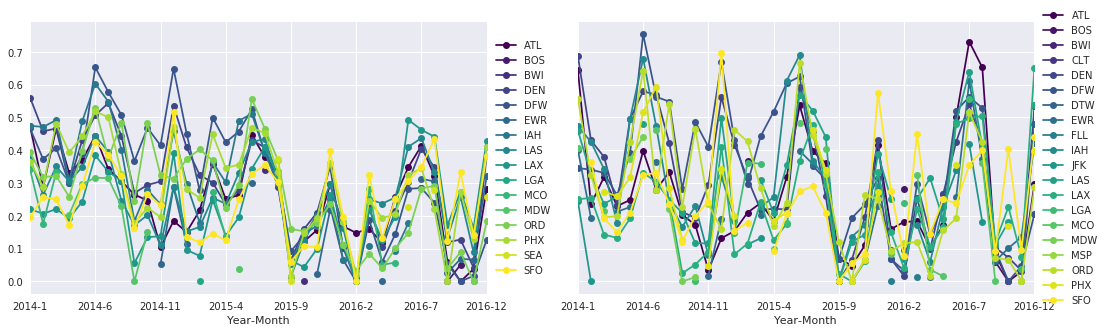

In [30]:
# Perform standardization to see the common trend shared across different airports
fig, ax = plt.subplots(1, 2, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(18)

yy_m, top_delay_freq = findTimeAirport(data[data['DepDelay']>0], airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='DepDelayMinutes', agg_way='count')
top_delay_freq = pd.DataFrame(top_delay_freq)
top_delay_freq_ori = top_delay_freq.copy()
top_delay_freq = standardization(top_delay_freq)
top_delay_freq['Year-Month'] = [str(yy_m[i]//100) + '-' + str(yy_m[i]-yy_m[i]//100*100) for i in range(len(yy_m))]
top_delay_freq.plot(x='Year-Month', marker='o',  cmap=plt.cm.get_cmap('viridis'), ax=ax[0])

yy_m, top_delay_min = findTimeAirport(data[data['DepDelay']>0], airptkey='Origin', timeperiod='YY-M', topn=10, agg_key='DepDelayMinutes', agg_way='sum')
top_delay_min = pd.DataFrame(top_delay_min)
top_delay_min_ori = top_delay_min.copy()
top_delay_min = standardization(top_delay_min)
top_delay_min['Year-Month'] = [str(yy_m[i]//100) + '-' + str(yy_m[i]-yy_m[i]//100*100) for i in range(len(yy_m))]
top_delay_min.plot(x='Year-Month', marker='o',  cmap=plt.cm.get_cmap('viridis'), ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [31]:
x_label = top_delay_min['Year-Month']
top_delay_freq.drop(labels='Year-Month', axis=1, inplace=True)
top_delay_min.drop(labels='Year-Month', axis=1, inplace=True)

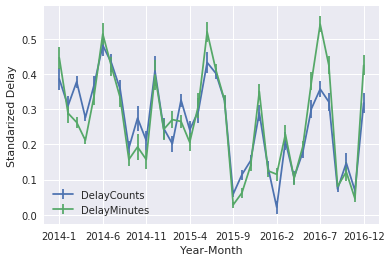

In [32]:
# Plot the average trend over year using delay frequency and delay counts
mean_freq = np.nanmean(top_delay_freq, axis=1)
std_freq = np.nanstd(top_delay_freq, axis=1)/np.sqrt(top_delay_freq.shape[1])

fig, ax = plt.subplots()

mean_min = np.nanmean(top_delay_min, axis=1)
ste_min = np.nanstd(top_delay_min, axis=1)/np.sqrt(top_delay_min.shape[1])

ax.errorbar(np.arange(len(mean_freq)), mean_freq, ste_min, label="DelayCounts")
ax.errorbar(np.arange(len(mean_min)), mean_min, ste_min, label="DelayMinutes")
ax.set_xticklabels(x_label[np.concatenate([np.zeros(1), np.arange(0, len(x_label),5)])])
ax.legend(loc='lower left')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Standarized Delay')

From the above figure we could see that delay severity (Delay Minutes) keeps more information related to time change within the year. Therefore, I'll look into factors to predict Delay Counts each month for each airport.

### Part C: Predict departure delay minutes for each airport per month

In [33]:
# Create dataframe with feature and target information
agg_dict = {
    'DepDelayMinutes':'sum', 
    'Month':'mean','DestAirportID':'count',
    'Carrier': [lambda col: set(col)],
    'AirlineID':[lambda col: len(set(col))], 
    'Dest':[lambda col: len(set(col))]
}
data_agg = data.groupby(['YY-M', 'Origin'], as_index = False).agg(agg_dict)
data_agg.columns = data_agg.columns.droplevel(1)

In [34]:
data_agg.rename(columns={'Dest': 'IncomingAirport#'}, inplace=True)
data_agg.rename(columns={'DestAirportID': 'BusyLevel'}, inplace=True)
data_agg.rename(columns={'AirlineID': 'DistinctCarrier#'}, inplace=True)

In [35]:
airport_target = list(top_delay_min.iloc[0][~top_delay_min.iloc[0].isnull()].sort_values(ascending=True).index)

In [36]:
data_agg_top10 = data_agg[data_agg['Origin'].isin(airport_target)]
season = ['winter', 'spring', 'summer', 'autumn']
month_map = {i:season[i//3] for i in range(12)}
data_agg_top10['Month'] = data_agg_top10['Month'].map(month_map)

In [37]:
data_agg_top10.head()

,YY-M,Origin,IncomingAirport#,BusyLevel,Month,Carrier,DepDelayMinutes,DistinctCarrier#
18,201401,ATL,153,30796,winter,"{F9, EV, OO, FL, WN, AS, DL, UA, AA, MQ, US}",583258.0,11
82,201401,DEN,132,17977,winter,"{EV, F9, OO, FL, WN, AS, B6, DL, UA, AA, MQ, US}",401653.0,12
83,201401,DFW,143,23488,winter,"{EV, F9, VX, OO, AS, B6, DL, UA, AA, MQ, US}",276937.0,11
99,201401,EWR,82,9267,winter,"{EV, VX, WN, AS, B6, DL, UA, AA, MQ, US}",215708.0,10
141,201401,IAH,108,14581,winter,"{F9, EV, OO, AS, DL, UA, AA, MQ, US}",239702.0,9


In [38]:
# Convert Carrier information using one-hot encoding
carrier_set = set()
carrier_list = list(data_agg_top10['Carrier'])
for i in range(data_agg_top10.shape[0]):
    carrier_set = carrier_set.union(carrier_list[i])

fillin_data = np.zeros((data_agg_top10.shape[0], len(carrier_set)))
carrier_df = pd.DataFrame(fillin_data, columns=list(carrier_set), index=data_agg_top10.index)

for j in range(data_agg_top10.shape[0]): 
    for k in carrier_list[j]:
        carrier_df.iloc[j][k] = 1

data_agg_top10_ori = data_agg_top10.copy()
data_agg_top10 = pd.concat([data_agg_top10, carrier_df], axis=1)
data_agg_top10.drop('Carrier', axis=1, inplace=True)

In [39]:
data_agg_top10.head()

,YY-M,Origin,IncomingAirport#,BusyLevel,Month,DepDelayMinutes,DistinctCarrier#,NK,F9,EV,...,AS,B6,HA,UA,MQ,WN,FL,DL,AA,US
18,201401,ATL,153,30796,winter,583258.0,11,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
82,201401,DEN,132,17977,winter,401653.0,12,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
83,201401,DFW,143,23488,winter,276937.0,11,0.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
99,201401,EWR,82,9267,winter,215708.0,10,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
141,201401,IAH,108,14581,winter,239702.0,9,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [40]:
le = LabelEncoder()
data_agg_top10['Origin'] = le.fit_transform(data_agg_top10['Origin'])

dummy_airport= pd.get_dummies(data_agg_top10['Origin'], prefix='Airport')
dummy_airport.drop('Airport_9', axis=1, inplace=True)
dummy_month = pd.get_dummies(data_agg_top10['Month'], prefix='Month')
dummy_month.drop('Month_winter', axis=1, inplace=True)

In [42]:
data_agg_top10 = pd.concat([data_agg_top10,dummy_airport, dummy_month], axis=1)

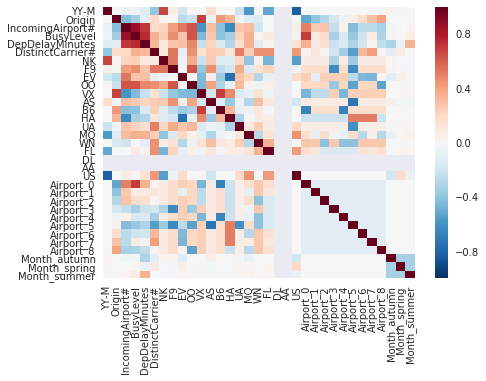

In [43]:
# Look into correlation between features
fig, ax = plt.subplots(figsize=(7,5)) 
sns.heatmap(data_agg_top10.corr())

According to the heat plot, we drop features to elimiate correlation between features.

In [44]:
# Drop redundant features
data_top10_fullmodel = data_agg_top10.copy()
drop_list = ['YY-M', 'Month','Origin', 'DistinctCarrier#', 'IncomingAirport#']
for k in drop_list:
    data_agg_top10.drop(k, inplace=True, axis=1)
data_top10_model = data_agg_top10.copy()

In [45]:
data_top10_model.head()

,BusyLevel,DepDelayMinutes,NK,F9,EV,OO,VX,AS,B6,HA,...,Airport_2,Airport_3,Airport_4,Airport_5,Airport_6,Airport_7,Airport_8,Month_autumn,Month_spring,Month_summer
18,30796,583258.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
82,17977,401653.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
83,23488,276937.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1,0,0,0,0,0,0,0,0,0
99,9267,215708.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,0
141,14581,239702.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


The assumption that we have to build random forest models is that target data is sampled from expectation model with Gaussian noise. Therefore, the target data should follow Gaussian distribution. However, the distribution of Departure delay minutes display heavy tail (shown below)

Normality test p_value = 0.000000 for DepDelayMinutes
Normality test p_value = 0.10 for log(DepDelayMinutes)


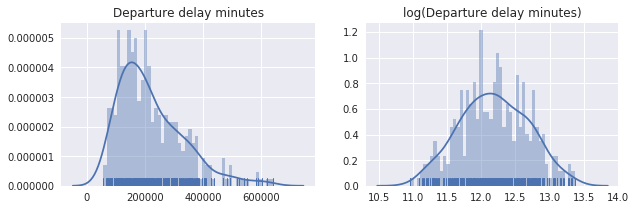

In [46]:
fig, ax = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

y = np.array(data_top10_model['DepDelayMinutes'].reshape(-1,1))
hist = sns.distplot(y, bins=50, rug=True, ax=ax[0])
# Perform nomality test
statistic, p_value = stats.shapiro(y)
print('Normality test p_value = %f for DepDelayMinutes'% (p_value))

y = np.log(y)
hist = sns.distplot(y, bins=50, rug=True,  ax=ax[1])
ax[0].set_title('Departure delay minutes')
ax[1].set_title('log(Departure delay minutes)')

# Perform nomality test
statistic, p_value = stats.shapiro(y)
print('Normality test p_value = %0.2f for log(DepDelayMinutes)'% (p_value))

From the above test we could see that log transform of departure delayed minutes follows Guassian distribution. Therefore, we will use log(departure delayed minutes) as target variable.

In [47]:
data_top10_model.drop(labels='DepDelayMinutes', axis=1, inplace=True)
x = np.array(data_top10_model)

In [48]:
data_top10_model.head()

,BusyLevel,NK,F9,EV,OO,VX,AS,B6,HA,UA,...,Airport_2,Airport_3,Airport_4,Airport_5,Airport_6,Airport_7,Airport_8,Month_autumn,Month_spring,Month_summer
18,30796,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
82,17977,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
83,23488,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
99,9267,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,0
141,14581,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0


In [49]:
# Build random forest regressor
params = {
    'n_estimators': np.arange(10, 300, 10)
}

def random_forest_regressor(df, data, test_size=0.2, params=params, seed=1, iffigure=True):

    x_train, x_test, y_train, y_test = data
    
    rf_rg = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf_rg.fit(x_train, y_train)
    y_train_pred = rf_rg.predict(x_train)
    y_pred = rf_rg.predict(x_test)
    
    select_feature_num = int(np.sqrt(len(rf_rg.feature_importances_)))
    indices = np.argsort(rf_rg.feature_importances_)
    importance = rf_rg.feature_importances_
    
    feature_importance = pd.DataFrame(importance[::-1]).T
    feature_importance.columns=list(df.columns[indices])
    if iffigure:
        feature_importance.iloc[0].sort_values(ascending=True)[-1 * select_feature_num:].plot.barh()
        plt.title('Feature Importance')
    
    # Perform hyperparameter search on number of paramters
    Grid_CV = GridSearchCV(estimator=rf_rg, param_grid=params, scoring='neg_mean_squared_error')
    Grid_CV.fit(x_train, y_train)
    
    best_estimator = Grid_CV.best_estimator_
    y_pred = best_estimator.predict(x_test)
    
    return best_estimator,y_train_pred, y_test, y_pred

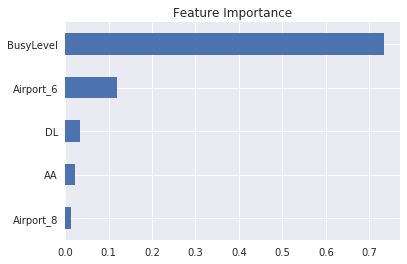

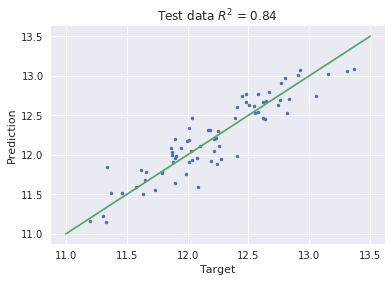

In [50]:
# Plot top 5 feature importance and R2 between target and prediction for test set
train_test_data = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)
best_estimator, y_train_pred, y_test, y_pred = random_forest_regressor(data_top10_model, train_test_data, seed=1, params=params)
test_perform = stats.linregress(y_test.reshape(1, -1), y_pred.reshape(1, -1))

plt.figure()
plt.plot(y_test, y_pred, '.', )
plt.plot(np.arange(11,14, 0.5), np.arange(11,14, 0.5))
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('Test data $R^2$ = %0.2f ' % test_perform[2] ** 2)

Next, we would like to include the informaiton of history departure delay minutes. To to do this, I'll use past 5 months departure delay minutes directly as paramter to train the model.

In [67]:
airport_id = sorted(list(data_top10_fullmodel['Origin'].value_counts().index))

In [68]:
data_top10_fullmodel_hist = pd.DataFrame(data=None)
for i in airport_id:
    table_pad = data_top10_fullmodel.iloc[:5]
    table_pad['DepDelayMinutes'] = 0
    data_airport = pd.concat([table_pad, data_top10_fullmodel[data_top10_fullmodel['Origin']==i]], axis=0)
    data_airport['DepDelayMinutes_sd'] = data_airport['DepDelayMinutes']
    min_1styear = np.nanmin(data_airport['DepDelayMinutes_sd'].iloc[5:17].values)
    max_1styear = np.nanmax(data_airport['DepDelayMinutes_sd'].iloc[5:17].values)                
    data_airport['DepDelayMinutes_sd'] = (data_airport['DepDelayMinutes_sd'] - min_1styear)/(max_1styear - min_1styear)
    hist_delay = pd.DataFrame(data=np.zeros((data_airport.shape[0], 5)), index=list(data_airport.index), columns=['M-1','M-2','M-3','M-4','M-5'])

    for j in range(4, data_airport.shape[0]):
        hist_delay.iloc[j] = list(data_airport['DepDelayMinutes_sd'][j-4:j+1])

    data_airport = data_airport.iloc[5:]
    hist_delay = hist_delay.iloc[5:]
    data_airport = pd.concat([data_airport, hist_delay], axis=1)
    data_top10_fullmodel_hist = data_top10_fullmodel_hist.append(data_airport)

data_top10_fullmodel_hist = data_top10_fullmodel_hist.iloc[5:]

In [69]:
data_top10_fullmodel_hist.head()

,YY-M,Origin,IncomingAirport#,BusyLevel,Month,DepDelayMinutes,DistinctCarrier#,NK,F9,EV,...,Airport_8,Month_autumn,Month_spring,Month_summer,DepDelayMinutes_sd,M-1,M-2,M-3,M-4,M-5
1534,201406,0,156,30934,summer,426736.0,11,0.0,1.0,1.0,...,0,0,0,1,0.597721,0.330074,0.466380,0.320352,0.351728,0.597721
1851,201407,0,157,31808,summer,350614.0,11,0.0,1.0,1.0,...,0,0,0,1,0.402079,0.466380,0.320352,0.351728,0.597721,0.402079
2166,201408,0,157,31569,summer,385624.0,11,0.0,1.0,1.0,...,0,0,0,1,0.492058,0.320352,0.351728,0.597721,0.402079,0.492058
2481,201409,0,151,30196,autumn,301857.0,11,0.0,1.0,1.0,...,0,1,0,0,0.276768,0.351728,0.597721,0.402079,0.492058,0.276768
2793,201410,0,148,31618,autumn,282301.0,11,0.0,1.0,1.0,...,0,1,0,0,0.226507,0.597721,0.402079,0.492058,0.276768,0.226507


In [77]:
data_top10_hist = data_top10_fullmodel_hist.copy()

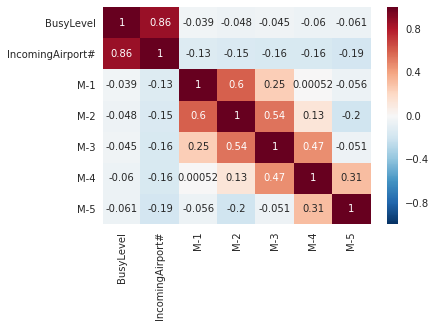

In [79]:
sns.heatmap(data_top10_hist[['BusyLevel','IncomingAirport#','M-1','M-2','M-3','M-4','M-5']].corr(), annot=True)

From the correlation coefficient the month next to each other have positive correlation. Therefore we will drop 'M-2' and 'M-4' as well as the redundant features.

In [80]:
y = np.log(np.array(data_top10_hist['DepDelayMinutes']).reshape(-1, 1))

drop_list = ['YY-M', 'Origin', 'DepDelayMinutes', 'DepDelayMinutes_sd','Month', 'DistinctCarrier#', 'M-2', 'M-4']
for k in drop_list:
    data_top10_hist.drop(k, inplace=True, axis=1)

x = np.array(data_top10_hist)

In [81]:
data_top10_hist.head()

,IncomingAirport#,BusyLevel,NK,F9,EV,OO,VX,AS,B6,HA,...,Airport_5,Airport_6,Airport_7,Airport_8,Month_autumn,Month_spring,Month_summer,M-1,M-3,M-5
1534,156,30934,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0.330074,0.320352,0.597721
1851,157,31808,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0.466380,0.351728,0.402079
2166,157,31569,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0.320352,0.597721,0.492058
2481,151,30196,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0.351728,0.402079,0.276768
2793,148,31618,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0.597721,0.492058,0.226507


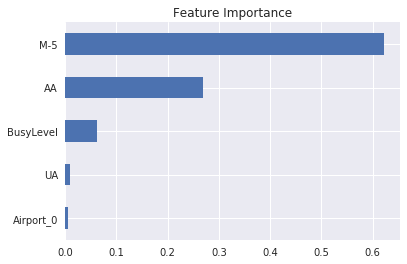

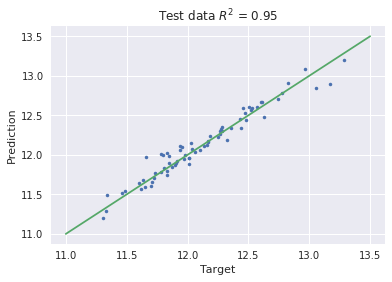

In [82]:
train_test_data = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=0)
best_estimator, y_train_pred, y_test, y_pred = random_forest_regressor(data_top10_hist, train_test_data, seed=10, params=params)
test_perform = stats.linregress(y_test.reshape(1, -1), y_pred.reshape(1, -1))

plt.figure()
plt.plot(y_test, y_pred, '.', )
plt.plot(np.arange(11,14, 0.5), np.arange(11,14, 0.5))
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('Test data $R^2$ = %0.2f' % test_perform[2] ** 2)

From the R2 we could see that including the past month departure delay minutes helps with the prediction performance. Previous seperation between training and testing set were based on random shuffling. To have a visualization of the predictor performance, next I will use the month before 201603 as training set and months after 201603 as testing to have a brief idea about the forcasting performance.

In [83]:
data_top10_hist_train = data_top10_fullmodel_hist[data_top10_fullmodel_hist['YY-M']<=201603]
data_top10_hist_test =  data_top10_fullmodel_hist[data_top10_fullmodel_hist['YY-M']>201603]
y_train = np.log(np.array(data_top10_hist_train['DepDelayMinutes']).reshape(-1, 1))
y_test = np.log(np.array(data_top10_hist_test['DepDelayMinutes']).reshape(-1, 1))

drop_list = ['YY-M', 'Origin', 'DepDelayMinutes', 'DepDelayMinutes_sd','Month', 'DistinctCarrier#', 'M-2', 'M-4']
for k in drop_list:
    data_top10_hist_train.drop(k, inplace=True, axis=1)
    data_top10_hist_test.drop(k, inplace=True, axis=1)

In [84]:
x_train = np.array(data_top10_hist_train)
x_test = np.array(data_top10_hist_test)

train_test_data = [x_train, x_test, y_train, y_test]
best_estimator, y_train_pred, y_test, y_pred = random_forest_regressor(data_top10_hist, train_test_data, seed=1, params=params, iffigure=False)

To have a visualization of the model performance, I'll use month before 2016-3 as training month after 2016-3 as testing data.

In [85]:
data_top10_hist_train = data_top10_fullmodel_hist[data_top10_fullmodel_hist['YY-M']<=201603]
data_top10_hist_test =  data_top10_fullmodel_hist[data_top10_fullmodel_hist['YY-M']>201603]
data_top10_hist_test['DepDelayMinutes'] = np.exp(y_pred)
data_top10_hist_train['DepDelayMinutes'] = np.exp(y_train_pred)
data_top10_hist_train = data_top10_hist_train.append(data_top10_hist_test)

In [86]:
top_delay_freq.head()

,ATL,BOS,BWI,DEN,DFW,EWR,IAH,LAS,LAX,LGA,MCO,MDW,ORD,PHX,SEA,SFO
0,0.472232,NaN,NaN,0.560062,0.466401,NaN,0.474343,0.373687,0.220469,NaN,0.341167,NaN,0.392992,0.365413,NaN,0.195030
1,0.287556,NaN,NaN,0.457619,0.372499,NaN,0.470713,0.263447,0.206121,NaN,0.175861,NaN,0.318226,0.287981,NaN,0.257351
2,0.465852,NaN,NaN,0.466004,0.406457,NaN,0.491489,0.350321,0.220564,NaN,0.332404,NaN,0.321444,0.480605,NaN,0.249935
3,0.330267,NaN,NaN,0.300401,0.300199,NaN,0.306383,0.304846,0.192444,NaN,NaN,0.203818,0.257868,0.393329,NaN,0.172131
4,0.369686,NaN,NaN,0.430277,0.386927,NaN,0.488360,0.348753,0.243520,NaN,NaN,0.297024,0.395999,0.442110,NaN,0.292220


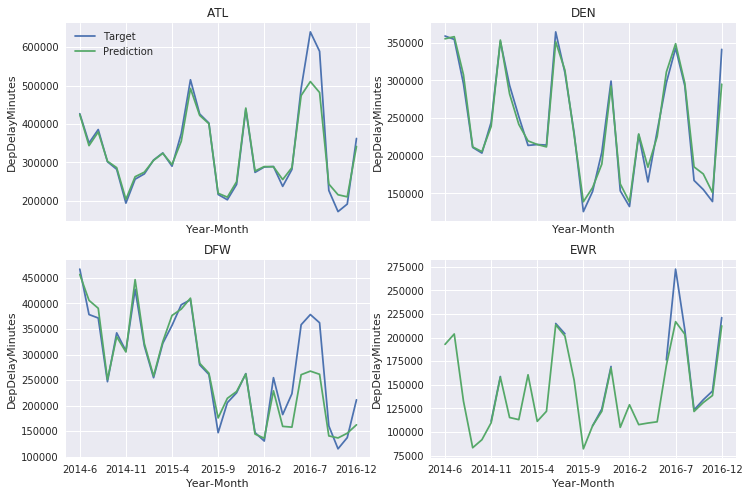

In [87]:
fig, ax = plt.subplots(2, 2, sharex=True)
fig.set_figheight(8)
fig.set_figwidth(12)

id_airport = le.inverse_transform(airport_id)

for i in range(2):
    for j in range(2):
        curr_index = i * 2 + j
        data_airport = data_top10_hist_train[data_top10_hist_train['Origin']==curr_index]
        ori_data_airport = top_delay_min_ori[id_airport[curr_index]]
        data_airport['DepDelayMinutes'][:5] = ori_data_airport['DepDelayMinutes'][5:]
        
        if curr_index == 0:
            ax[i][j].plot(ori_data_airport.values, label='Target')
            ax[i][j].plot(data_airport['DepDelayMinutes'].values, label='Prediction')
            ax[i][j].set_xticklabels(x_label[np.concatenate([np.zeros(1), np.arange(5, len(x_label),5)])])
            ax[i][j].set_xlabel('Year-Month')
            ax[i][j].set_ylabel('DepDelayMinutes')
            ax[i][j].set_title(id_airport[curr_index])
        else:
            ax[i][j].plot(ori_data_airport.values, label='Target')
            ax[i][j].plot(data_airport['DepDelayMinutes'][5:].values, label='Prediction')
            ax[i][j].set_xticklabels(x_label[np.concatenate([np.zeros(1), np.arange(5, len(x_label),5)])])
            ax[i][j].set_xlabel('Year-Month')
            ax[i][j].set_ylabel('DepDelayMinutes')
            ax[i][j].set_title(id_airport[curr_index])
            
ax[0][0].legend()

From the result we can see that even we train the model within out shuffling the data, the regressor is still predicting the trend. There are still spaces for improving the performance, including reduce the feature numbers, inspect error study etc.

### PartD: Airline delay

In [ ]:
data = data_fl.copy()

To analyze the flight delay information, we could look into either the total minutes of delay or mean delay (total delay / number of flights)

In [311]:
data[data['ArrDel15']==0]['ArrDelayMinutes'].describe()

count    659030.000000
mean          9.210682
std           3.914636
min           0.000000
25%           7.000000
50%          10.000000
75%          12.000000
max          14.000000
Name: ArrDelayMinutes, dtype: float64

In [195]:
data[data['DepDel15']==0]['DepDelayMinutes'].describe()

count    685697.000000
mean          6.799664
std           5.327902
min           0.000000
25%           0.000000
50%           8.000000
75%          12.000000
max          14.000000
Name: DepDelayMinutes, dtype: float64

We could see that only delays >= 15 minutes are considered as delays. Therefore, we look into flights that were marked as dealy and compare the total and mean delay minutes among the airlines.

In [240]:
df_delay = data[(data['ArrDel15']==1)|(data['DepDel15']==1)]
df_delay['TT_Delay'] = df_delay['ArrDelayMinutes'] + df_delay['DepDelayMinutes']

In [248]:
airline_name = list(airline_tt_delay.index)

In [242]:
airline_tt_delay = df_delay.groupby(['Carrier']).agg({'ArrDelayMinutes':'sum','DepDelayMinutes':'sum', 'FlightDate':'count'})
airline_tt_delay.rename(columns={'FlightDate':'FlightCounts'}, inplace=True)

In [243]:
airline_tt_delay['TTDelayMinutes'] = airline_tt_delay['ArrDelayMinutes'] + airline_tt_delay['DepDelayMinutes']
airline_tt_delay['MeanDelayMinutes'] = airline_tt_delay['TTDelayMinutes']/airline_tt_delay['FlightCounts']

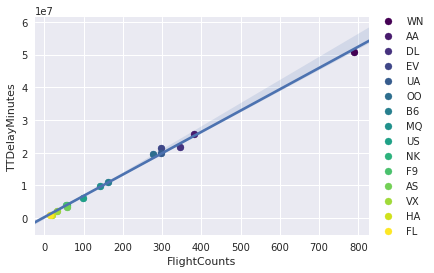

In [250]:
cmap=cm.viridis(np.linspace(0,1,len(airline_name)))
sns.regplot(airline_tt_delay['FlightCounts']/1000, airline_tt_delay['TTDelayMinutes'])

for i in range(len(airline_name)):
    plt.scatter(airline_tt_delay.iloc[i]['FlightCounts']/1000, airline_tt_delay.iloc[i]['TTDelayMinutes'], label=airline_name[i], color=cmap[i])

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Given the mean values of delay minutes are close to the regression line, we could see that the mean values of delay minutes are similar among airlines. But we need to run hypothesis test to see if their mean are the same.

In [251]:
airline_tt_delay = airline_tt_delay.sort_values(by='MeanDelayMinutes', ascending=False)
airline_tt_delay.iloc[0]

FlightCounts        2.979610e+05
ArrDelayMinutes     1.101682e+07
DepDelayMinutes     1.032419e+07
TTDelayMinutes      2.134101e+07
MeanDelayMinutes    7.162349e+01
Name: EV, dtype: float64

In [252]:
airline_tt_delay = airline_tt_delay.sort_values(by='TTDelayMinutes', ascending=False)
airline_tt_delay.iloc[0]

FlightCounts        7.892910e+05
ArrDelayMinutes     2.467174e+07
DepDelayMinutes     2.615316e+07
TTDelayMinutes      5.082490e+07
MeanDelayMinutes    6.439311e+01
Name: WN, dtype: float64

Therefore, EV has the longest mean dealy and WN has the longest total delayed time.

In [253]:
airline_mean_delay = data.groupby(['Carrier']).agg({'ArrDelayMinutes':'mean','DepDelayMinutes':'mean', 'AirlineID':'count'})
airline_mean_delay['MeanDelayMinutes'] = (airline_mean_delay['ArrDelayMinutes'] + airline_mean_delay['DepDelayMinutes'])/2
airline_mean_delay.columns = airline_mean_delay.columns
airline_mean_delay.rename(columns={'AirlineID': 'Counts'}, inplace=True)

Next, we will run statistical analysis on delay minutes data of each airline to see if they really have mean delay minutes. Our null hypothesis is that all airlines have the same mean delay minutes, versus the alternative hypothesis that some airline has different mean delay comparing with others.

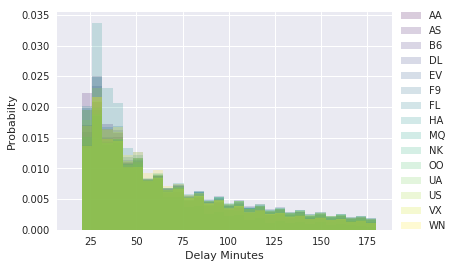

In [339]:
for i in range(15):
    n, bins, patches = plt.hist(df_delay[df_delay['Carrier']==airplane_name[i]]['total_delay'], 
                                range = (15,180), normed=True, bins= 30, alpha=0.2, label=airplane_name[i], color=cmap[i])

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Delay Minutes')
plt.ylabel('Probabilty')

From the overlapping of the distribution, it starts appearing some difference among the airline. Given the heavy tailed distribution of delay time data, I take the log of the original data and applied F-test with post-hoc multicomparison.

In [272]:
data_delay = []

for i in range(len(airline_mean_delay.index)):
    data_tmp = df_delay[df_delay['Carrier']==airplane_name[i]]['total_delay']
    data_delay.append(np.log(data_tmp[(~data_tmp.isnull())].values[:5000]))
    
data_arr = np.vstack(data_delay)

stats.f_oneway(*data_delay)

F_onewayResult(statistic=221.08149722815583, pvalue=0.0)

From the F-test result we could see that the null hypothesis is rejected, mean of delay times among multiple airlines are not the same.

In [328]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

group = np.hstack([[np.ones(5000) * i] for i in np.arange(15)]).reshape(-1,1)
result = pairwise_tukeyhsd(data_arr.reshape(-1,1), group)

In [301]:
result.summary()

group1,group2,meandiff,lower,upper,reject
0.0,1.0,-0.1165,-0.156,-0.0771,True
0.0,2.0,0.0483,0.0089,0.0877,True
0.0,3.0,0.0893,0.0498,0.1287,True
0.0,4.0,0.1346,0.0952,0.174,True
0.0,5.0,0.0182,-0.0212,0.0576,False
0.0,6.0,-0.0769,-0.1163,-0.0375,True
0.0,7.0,-0.2331,-0.2725,-0.1937,True
0.0,8.0,0.1155,0.0761,0.1549,True
0.0,9.0,0.0255,-0.0139,0.065,False
0.0,10.0,0.0411,0.0017,0.0805,True


In [302]:
airline_name[7]

'MQ'

From the result we could find out that mean of 'MQ' is higher than all the other group members.

### Part E: Predict whether a specific flight will be delayed

In [ ]:
# Select features for construct the model and prediction, here we will try to predict arrival delay
# Create balacned class by down sampling the non-delay group.Better down sampling methods could be tested
data_pred_delay = data[(data['ArrDel15']==1)|(data['DepDel15']==1)]
rndperm = np.random.permutation(2500000)
data_pred_nodelay = data[(data['ArrDel15']==0)].iloc[rndperm]

In [47]:
data_pred = pd.concat([data_pred_delay, data_pred_nodelay.iloc[rndperm]], axis=0)
columns = ['ArrDel15', 'Month', 'DayOfWeek', 'Distance', 'Carrier', 'DepTimeBlk', 'Origin', 'Dest']
feature_list = [data_pred[i] for i in columns]

data_pred_delay = pd.concat(feature_list, axis=1)

In [48]:
# Convert Origin and Dest airport to busy level
mean_busy = np.mean(top150_busy_df['FlightCounts'])
std_busy = np.std(top150_busy_df['FlightCounts'])

top150_busy_df['FlightCounts'] = (top150_busy_df['FlightCounts'] - mean_busy)/std_busy

busy_dict = {}
for i in range(len(top150_busy_df)):
    busy_dict[top150_busy_df.iloc[i]['IATA']] = top150_busy_df.iloc[i]['FlightCounts']
    
fillin_val = top150_busy_df.iloc[-1]['FlightCounts']
data_pred_delay['Origin'] = data_pred_delay['Origin'].map(busy_dict)
data_pred_delay['Origin'].fillna(fillin_val, inplace=True)
data_pred_delay['Dest'] = data_pred_delay['Dest'].map(busy_dict)
data_pred_delay['Dest'].fillna(fillin_val, inplace=True)

In [49]:
data_pred_delay.head()

,ArrDel15,Month,DayOfWeek,Distance,Carrier,DepTimeBlk,Origin,Dest
3,1.0,1,6,2475.0,AA,0900-0959,1.086984,3.122089
4,1.0,1,7,2475.0,AA,0900-0959,1.086984,3.122089
5,0.0,1,1,2475.0,AA,0900-0959,1.086984,3.122089
7,0.0,1,3,2475.0,AA,0900-0959,1.086984,3.122089
9,1.0,1,5,2475.0,AA,0900-0959,1.086984,3.122089


In [50]:
# Transform month into 4 categories
season = ['winter', 'spring', 'summer', 'autumn']
month_map = {i:season[i//3] for i in range(12)}
data_pred_delay['Month'] = data_pred_delay['Month'].map(month_map)
# Transform month into 4 categories
week_map = {1:'W-1-5', 2:'W2-4', 3: 'W2-4', 4:'W2-4', 5:'W-1-5', 6:'W6-7', 7:'W6-7'}
data_pred_delay['DayOfWeek'] = data_pred_delay['DayOfWeek'].map(week_map)

In [51]:
# Transform carrier
le = LabelEncoder()
data_pred_delay['Carrier'] = le.fit_transform(data_pred_delay['Carrier'])

dummy_airport= pd.get_dummies(data_pred_delay['Carrier'], prefix='Carrier')
dummy_airport.drop('Carrier_0', axis=1, inplace=True)
dummy_month = pd.get_dummies(data_pred_delay['Month'], prefix='Month')
dummy_month.drop('Month_winter', axis=1, inplace=True)
dummy_week = pd.get_dummies(data_pred_delay['DayOfWeek'], prefix='Week')
dummy_week.drop('Week_W2-4', axis=1, inplace=True)

data_pred_delay = pd.concat([data_pred_delay ,dummy_airport, dummy_month, dummy_week], axis=1)

In [52]:
data_pred_delay['DepTimeBlk'] = data_pred_delay['DepTimeBlk'].map(lambda x: int(x[:2]))

In [54]:
data_pred_delay.dropna(axis=0, how='any', inplace=True)

In [57]:
data_pred_delay.head()

,ArrDel15,Month,DayOfWeek,Distance,Carrier,DepTimeBlk,Origin,Dest,Carrier_1,Carrier_2,...,Carrier_10,Carrier_11,Carrier_12,Carrier_13,Carrier_14,Month_autumn,Month_spring,Month_summer,Week_W-1-5,Week_W6-7
3,1.0,winter,W6-7,2475.0,0,9,1.086984,3.122089,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,winter,W6-7,2475.0,0,9,1.086984,3.122089,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.0,winter,W-1-5,2475.0,0,9,1.086984,3.122089,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0.0,winter,W2-4,2475.0,0,9,1.086984,3.122089,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1.0,winter,W-1-5,2475.0,0,9,1.086984,3.122089,0,0,...,0,0,0,0,0,0,0,0,1,0


In [77]:
y = np.array(data_pred_delay['ArrDel15']).reshape(-1,1)
drop_list = ['Month', 'DayOfWeek', 'Carrier', 'ArrDel15']
for k in drop_list:
    data_pred_delay.drop(k, inplace=True, axis=1)

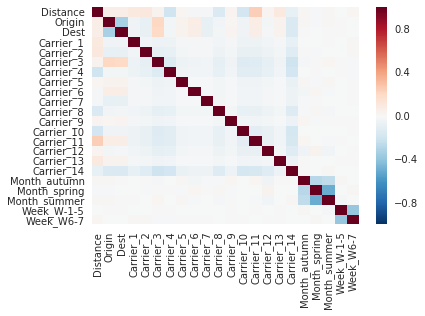

In [62]:
sns.heatmap(data_pred_delay.corr())

From the correlation coefficient, we could see that features are not correlated between each pair.

In [63]:
x = np.array(data_pred_delay)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1)

In [64]:
# Standardize data
standscaler = StandardScaler()
x_train_scaled = standscaler.fit_transform(x_train)
x_test_scaled = standscaler.transform(x_test)

In [75]:
# Create logistic regression classifier
from sklearn.linear_model import LogisticRegression

lg_rg_strong_l1 = LogisticRegression(penalty='l1', C=0.00001, random_state=2)
lg_rg_strong_l1.fit(x_train_scaled, y_train)
lg_rg_strong_l1_result = pd.DataFrame(lg_rg_strong_l1.coef_, columns=data_pred_delay.columns)
lg_rg_strong_l1_result.T.sort_values(by=0).T

,Month_spring,Carrier_3,Carrier_12,Carrier_6,Distance,Carrier_14,Carrier_13,Carrier_11,Carrier_10,Week_W-1-5,...,Carrier_2,Carrier_1,Dest,Origin,Carrier_7,Week_W6-7,Month_summer,Carrier_9,DepTimeBlk,Month_autumn
0,-0.1135,-0.025781,-0.020905,-0.016949,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.054263,0.077832,0.225669,0.456633


In [66]:
lg_rg_weak_l1 = LogisticRegression(penalty='l1', C=1, random_state=2)
lg_rg_weak_l1.fit(x_train_scaled, y_train)
lg_rg_weak_l1_result = pd.DataFrame(lg_rg_weak_l1.coef_, columns=data_pred_delay.columns)
lg_rg_weak_l1_result.T.sort_values(by=0).T

,Carrier_3,Carrier_12,Carrier_6,Month_spring,Carrier_1,Carrier_7,Carrier_8,Carrier_10,Week_W6-7,Carrier_11,...,Distance,Carrier_2,Carrier_5,Week_W-1-5,Origin,Dest,Month_summer,Carrier_9,DepTimeBlk,Month_autumn
0,-0.202298,-0.149248,-0.147072,-0.114387,-0.094526,-0.087059,-0.074061,-0.068765,-0.065461,-0.060311,...,-0.024651,0.00105,0.014646,0.020286,0.040643,0.053766,0.163883,0.187337,0.317609,0.603719


In [67]:
# Cross validation
from sklearn import cross_validation

def modelfit(alg, x_train, y_train, performCV=True, cv_folds=5):
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, x_train, y_train, cv=cv_folds, scoring='f1_macro')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

In [68]:
from sklearn.model_selection import ParameterGrid

params = {
    'penalty': ['l1', 'l2'],
    'C': [0.00001, 0.0001, 0.001, 0.01]
}

param_grid = ParameterGrid(params)

for i in range(len(param_grid)):
    alg = LogisticRegression(random_state=2, **param_grid[i])
    
    modelfit(alg, x_train_scaled, np.squeeze(y_train))


Model Report
Accuracy : 0.6358
CV Score : Mean - 0.6219291 | Std - 0.0003122378 | Min - 0.6215524 | Max - 0.6224668

Model Report
Accuracy : 0.6445
CV Score : Mean - 0.6401544 | Std - 0.0005593714 | Min - 0.6392881 | Max - 0.6407541

Model Report
Accuracy : 0.6441
CV Score : Mean - 0.6395491 | Std - 0.0005445786 | Min - 0.6387837 | Max - 0.6402565

Model Report
Accuracy : 0.6447
CV Score : Mean - 0.6403381 | Std - 0.0004791055 | Min - 0.6396828 | Max - 0.6409565

Model Report
Accuracy : 0.6447
CV Score : Mean - 0.6403137 | Std - 0.0004852654 | Min - 0.6395979 | Max - 0.6409533

Model Report
Accuracy : 0.6447
CV Score : Mean - 0.6403861 | Std - 0.0005122181 | Min - 0.6396701 | Max - 0.6410517

Model Report
Accuracy : 0.6447
CV Score : Mean - 0.6403933 | Std - 0.0005006787 | Min - 0.6396686 | Max - 0.6410434

Model Report
Accuracy : 0.6447
CV Score : Mean - 0.6403869 | Std - 0.0005034682 | Min - 0.6396701 | Max - 0.641016


In [76]:
# Choose parameter with the highest CV score
lg_rg = LogisticRegression(penalty='l2', C=0.0001, random_state=2)
lg_rg.fit(x_train_scaled, y_train)
y_pred =lg_rg.predict(x_test_scaled)
print ("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, y_pred))

Test Accuracy : 0.6438


Given that l1 regularization promote sparseness at feature domain, increasing the l1 regularization will promote features that have strongest covariate with the target variable. l2 regulaization will uniformly scale down the weights. Although l2 regularization achieves the accuracy from the cv result, it will not enable feature selection. I use f_score as my cross validation score for the reason of imbalance in class. The CV score indicates that the model performance is not very good. This is possibly due to that logistic regression is a linear classifier and could only identify linear boundary, more feature engineering is also necessary to improve the model performance as well.  

### Part F:  Visualize airline in feature space

From the above result we could see that 'DepTimeBlk', 'Month', 'Origin', 'Dest' are significant covariates for predicting the delay of airlines after enhancing l1 regularizer.The two commonly used dimensionaly reduction methods are PCA and t-SNE.  PCA uses correlation between dimensions to provide a reduced number of variables that keeps the maximum amount of variation or information about how the original data is distributed. It is a linear transformation method. t-Distributed Stochastic Neighbor Embedding (t-SNE) performs dimensionality reduction through probabilistic approach, and is a nonlinear transoform. Given the performance of logistic regression classifier, linear transformation may not be good enough to seperate the groups, therefore I think t-SNE will be a better approach. But both of approaches should be tested. We could use fsklearn.decomposition.PCA and sklearn.manifold.TSNE to obtain dimensionality reduction, and ggpplot for the plotting.